# MMLDT-CSET 2021

# Short course Tutorial 3B:

# Elastic energy functional - Sobolev training

Instructors: Prof. Waiching Sun, Zeyu Xiong (Columbia University)

## Outline

1. Data generation

2. Sobolev training

3. Uniaxial testing

4. Validation of convexity

## 1. Data generation

The hyperelastic energy functional is shown below.

$$
W(\boldsymbol{F})=\frac{\kappa}{2} (J-1)^2 + \mu(\frac{I_1}{J^{2/3}}-3)
$$

$$
\boldsymbol{P}=\frac{\partial W}{\partial\boldsymbol{F}}=
\kappa J(J-1)\boldsymbol{F}^{-T} + \frac{\mu}{J^{2/3}}(\boldsymbol{F}-\frac{1}{3} I_1\boldsymbol{F}^{-T})
$$

where $\kappa$ is the bulk modulus, $\mu$ is the shear modulus, $\boldsymbol{F}$ is the deformation gradient, $W$ is the energy functional, $\boldsymbol{P}$ is the 1st Piola-Kirchhoff stress tensor, $I_1=\boldsymbol{F}:\boldsymbol{F}$, $J=\det(\boldsymbol{F})$.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

# define material parameters
k = 1./3     # bulk modulus
mu = 0.5    # shear modulus

# generate data of F, P, and W
F_train = []
P_train = []
W_train = []
for m in range(10100):

  # generate F based on random functions
	F = (np.random.rand(2,2)-0.5)*0.75+np.eye(2)

  # compute P and W from F
	J = np.linalg.det(F)
	I1 = np.linalg.norm(F)**2+1
	W = k/2*(J-1)**2+mu/2*(I1/J**(2/3)-3)
	P = ( k*J*(J-1)-1/3*mu/J**(2/3)*I1 )*np.linalg.inv(F).transpose() + mu/J**(2/3)*F

	F_train.append(F)
	W_train.append(W)
	P_train.append(P)
 
# covert the data into numpy arrays
F_train = np.array(F_train)
W_train = np.array(W_train)
P_train = np.array(P_train)

# split the test and train set
F_test = F_train[10000:10100]
W_test = W_train[10000:10100]
P_test = P_train[10000:10100]
F_train = F_train[0:10000]
W_train = W_train[0:10000]
P_train = P_train[0:10000]

# save the data in a dictionary
data = {'F_train': F_train, 'F_test': F_test,
	'W_train': W_train, 'W_test': W_test,
	'P_train': P_train, 'P_test': P_test}

## 2. Sobolev training

The data is loaded and preprocessed into the set of 2nd Piola-Kirchhoff stress tensor $\boldsymbol{S}$ and Green-Lagrange strain tensor $\boldsymbol{E}$. 

$$
\boldsymbol{C}=\boldsymbol{F}^T\boldsymbol{F}, \boldsymbol{E}=\frac{\boldsymbol{C}-\boldsymbol{I}}{2}
$$
$$
\boldsymbol{S}=\frac{\partial W}{\partial\boldsymbol{E}}=\boldsymbol{F}^{-1}\boldsymbol{P}
$$

where $\boldsymbol{C}$ is called Cauchy-Green tensor. By doing so, the data used for sobolev training become symmetric tensors, which reduces the dimension of the training data.

$$
X_{train}^{(i)}=\begin{bmatrix}
E_{11}^{(i)}\\
E_{22}^{(i)}\\
2E_{12}^{(i)}\\
\end{bmatrix}
$$

$$
y_{train}^{(i)}=W^{(i)}
$$

$$
dX_{train}^{(i)}=\frac{\partial y_{train}^{(i)}}{\partial X_{train}^{(i)}}=\begin{bmatrix}
S_{11}^{(i)}\\
S_{22}^{(i)}\\
S_{12}^{(i)}\\
\end{bmatrix}
$$


In [2]:
import torch
import torch.nn as nn

train_size = 10000

# load data
X_train = np.zeros((train_size,3)).astype(np.float32)
X_test = np.zeros((100,3)).astype(np.float32)
y_train = np.zeros((train_size,1)).astype(np.float32)
y_test = np.zeros((100,1)).astype(np.float32)
dX_train = np.zeros((train_size,3)).astype(np.float32)
dX_test = np.zeros((100,3)).astype(np.float32)

# process the data in the following way:
# compute E by (F^T*F-I)/2
# compute S by F^(-1)*P
F_train = data['F_train']
P_train = data['P_train']
W_train = data['W_train']
for m in range(train_size):
    F = F_train[m].reshape((2,2))
    C = np.dot(F.transpose(),F)
    E = (C-np.eye(2))/2
    S = np.dot(np.linalg.inv(F), P_train[m].reshape((2,2)))
    X_train[m] = [E[0][0], E[1][1], 2*E[0][1]]
    dX_train[m] = [S[0][0], S[1][1], S[0][1]]
    y_train[m][0] = W_train[m]

# process the test data in the same way
F_test = data['F_test']
P_test = data['P_test']
W_test = data['W_test']
for m in range(100):
    F = F_test[m].reshape((2,2))
    C = np.dot(F.transpose(),F)
    E = (C-np.eye(2))/2
    S = np.dot(np.linalg.inv(F), P_test[m].reshape((2,2)))
    X_test[m] = [E[0][0], E[1][1], 2*E[0][1]]
    dX_test[m] = [S[0][0], S[1][1], S[0][1]]
    y_test[m][0] = W_test[m]

# covert the data into torch tensors
X_train = torch.from_numpy(X_train)
X_train.requires_grad= True
X_test = torch.from_numpy(X_test)
X_test.requires_grad = True
dX_train = torch.from_numpy(dX_train)
dX_test = torch.from_numpy(dX_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

/home/hector/miniconda3/envs/MMLDT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create a Multi-Layer Perceptron (MLP) to describe the energy functional $W$ with repect the Green-Lagrange strain tensor $\boldsymbol{E}$.

In [3]:
class MLP(nn.Module):
    def __init__(self, size=[3,32,32,1]):
        super(MLP,self).__init__()
        self.d1 = nn.Linear(size[0],size[1])
        self.act1 = nn.ELU(alpha=1)
        self.d2 = nn.Linear(size[1],size[2])
        self.act2 = nn.ELU(alpha=1)
        self.d3 = nn.Linear(size[2],size[3])

    def forward(self,x):
        x = self.d1(x)
        x = self.act1(x)
        x = self.d2(x)
        x = self.act2(x)
        out = self.d3(x)
        return out

Compared to the regular supervised learning, the sobolev training has the loss function with an additional term  penalizing the difference in the gradient of the functional.

$$
L=\frac{1}{m}\sum_{i=1}^m ||W^{(i)}-\hat{W}^{(i)}||^2+\frac{1}{m}\sum_{i=1}^m||\frac{\partial W^{(i)}}{\partial\boldsymbol{E}}-\frac{\partial \hat{W}^{(i)}}{\partial\boldsymbol{E}}||^2
$$

In [4]:
# define hyperparameters
learning_rate = 0.005
num_epochs = 1500

# initialize the model, loss function and optimizer
device = torch.device('cpu')
model = MLP([3,32,32,1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train the model with the data
for epoch in range(num_epochs):

    # initialize the loss
    train_running_loss = 0.0
    test_loss = 0.0
    
    # compute y_pred and dX_pred = (d y_pred)/(d X_train)
    X_train = torch.from_numpy(X_train.detach().numpy())
    X_train.requires_grad=True
    y_pred = model(X_train)
    external_grad = torch.ones_like(y_pred)
    y_pred.backward(gradient=external_grad, retain_graph=True, create_graph=True)
    dX_pred = X_train.grad 
    
    # compute the loss from the predictions and the ground truth
    loss = criterion(dX_pred, dX_train) + criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_running_loss = loss.detach().item()

    # compute the test loss in the same way
    y_pred = model(X_test)
    external_grad = torch.ones_like(y_pred)
    y_pred.backward(gradient=external_grad, retain_graph=False)
    dX_pred = X_test.grad
    test_loss = criterion(dX_pred,dX_test) + criterion(y_pred, y_test)
    X_test.grad.data.zero_()
    
    # print the loss every 100 epochs
    if epoch%100==0:    
        print('Epoch: %d | Loss = %.8f | Test Loss = %.8f'%(epoch, train_running_loss, test_loss))

/home/hector/miniconda3/envs/MMLDT/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136134696/work/torch/csrc/autograd/engine.cpp:995.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 | Loss = 0.18506753 | Test Loss = 0.15600602
Epoch: 100 | Loss = 0.02785472 | Test Loss = 0.02661417
Epoch: 200 | Loss = 0.00588363 | Test Loss = 0.00354405
Epoch: 300 | Loss = 0.00259004 | Test Loss = 0.00123879
Epoch: 400 | Loss = 0.00169777 | Test Loss = 0.00078252
Epoch: 500 | Loss = 0.00126091 | Test Loss = 0.00054185
Epoch: 600 | Loss = 0.00448348 | Test Loss = 0.00298408
Epoch: 700 | Loss = 0.00074721 | Test Loss = 0.00023437
Epoch: 800 | Loss = 0.00061980 | Test Loss = 0.00020831
Epoch: 900 | Loss = 0.00053770 | Test Loss = 0.00020327
Epoch: 1000 | Loss = 0.00050062 | Test Loss = 0.00023592
Epoch: 1100 | Loss = 0.00048655 | Test Loss = 0.00022153
Epoch: 1200 | Loss = 0.00037339 | Test Loss = 0.00027032
Epoch: 1300 | Loss = 0.00031340 | Test Loss = 0.00018547
Epoch: 1400 | Loss = 0.00027815 | Test Loss = 0.00016679


## 3. Uniaxial testing

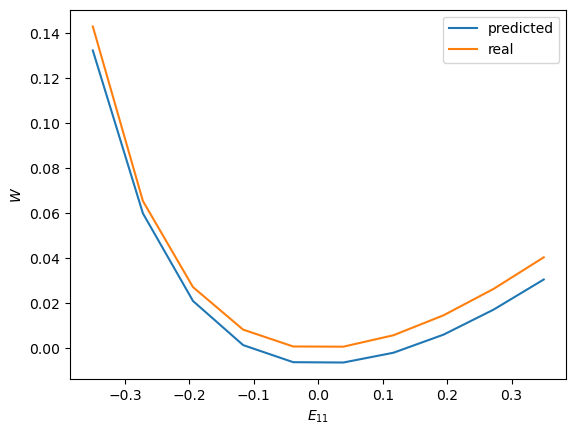

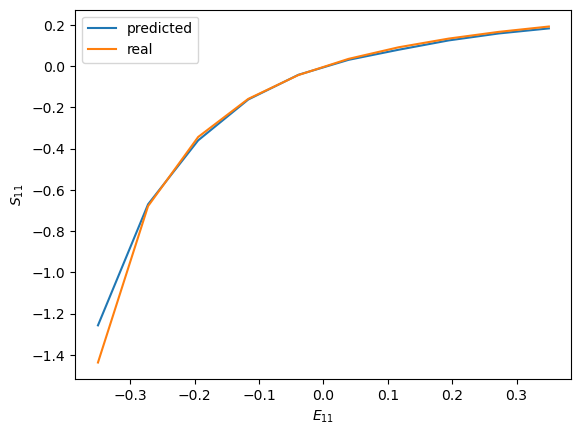

In [5]:
k = 1./3
mu = 0.5
# test with uniaxial strain
E11= np.linspace(-0.35, 0.35 ,10).astype(np.float32)
eps = np.zeros((10,3)).astype(np.float32)
eps[:,0] = E11
eps[:,1] = 0
eps[:,2] = 0

# covert the array into a torch tensor
eps = torch.from_numpy(eps)
eps.requires_grad=True

# compute the predicted energy functional and stress
Psi = model(eps)
Psi.backward(gradient=torch.ones_like(Psi))
stress=eps.grad

# plot the predicted and true energy functionals
plt.figure(1)
plt.plot(E11, Psi.detach().numpy().reshape(-1))
J = np.sqrt(1+2*E11)
Psi_true = k/2*(J-1)**2 + mu/2*((3+2*E11)/J**(2/3) - 3)
plt.plot(E11, Psi_true)
plt.xlabel('$E_{11}$')
plt.ylabel('$W$')
plt.legend(['predicted', 'real'])

# plot the predicted and true stresses
plt.figure(2)
plt.plot(E11, stress.detach().numpy()[:,0])
stress_true = k*J*(J-1)/(1+2*E11) + mu/J**(2/3) * 4/3*E11/(1+2*E11)
plt.plot(E11, stress_true)
plt.xlabel('$E_{11}$')
plt.ylabel('$S_{11}$')
plt.legend(['predicted', 'real'])
plt.show()


## 4. Validation of convexity

When solving computational mechanics problems, the convexity of the energy functional might be desired to ensure numerical stability, and the convexity is defined below.
$$
\forall \boldsymbol{E}_1,\boldsymbol{E}_0, W(\boldsymbol{E}_1)-W(\boldsymbol{E}_0)-\boldsymbol{S}(\boldsymbol{E}_0):(\boldsymbol{E}_1-\boldsymbol{E}_0)\geq 0 
$$

However, the sobolev training results may not guarantee convexity, as shown by the test code below. 

In [6]:
# randomly select the test samples
# to save time, reuse the train data
F_test = data['F_train']
P_test = data['P_train']
W_test = data['W_train']

# compute the number of violations of convexity
count=0
for t in range(100000):
    # select two samples
    I = np.random.choice(10000,2)
    F0 = F_test[I[0]] 

    # compute E0, S(E0), W(E0)
    E0 = (np.dot(F0.transpose(),F0)-np.eye(2))/2
    X0 = np.array([[E0[0,0], E0[1,1], 2*E0[0,1]]])
    X0 = torch.tensor(X0.astype(np.float32))
    X0.requires_grad = True
    W0 = model(X0)
    W0.backward(gradient=torch.ones_like(W0))
    S0 = X0.grad.detach().numpy()
    S0 = np.array([ [S0[0,0], S0[0,2]], [S0[0,2], S0[0,1]] ])
    P0 = np.dot(F0,S0)
    
    # compute E1, W(E1)
    F1 = F_test[I[1]]
    E1 = (np.dot(F1.transpose(),F1)-np.eye(2))/2
    X1 = np.array([[E1[0,0], E1[1,1], 2*E1[0,1]]])
    X1 = torch.tensor(X1.astype(np.float32))
    W1 = model(X1)
    
    # count if a violation of convexity is found
    if W1-W0-np.trace(np.dot(S0.transpose(), E1-E0)) < 0:
        count += 1
print('number of exceptions:', count)


number of exceptions: 0


To enforce convexity, an additional term penalizing the nonconvex elastic energy is added.
$$
L=\frac{1}{m}\sum_{i=1}^m ||W^{(i)}-\hat{W}^{(i)}||^2+\frac{1}{m}\sum_{i=1}^m||\frac{\partial W^{(i)}}{\partial\boldsymbol{E}}-\frac{\partial \hat{W}^{(i)}}{\partial\boldsymbol{E}}||^2 + \frac{1}{m}\sum_{i=1}^m relu[\boldsymbol{\hat{S}}^{(i)}:\delta\boldsymbol{E}^{(i)}+\hat{W}^{(i)}(\boldsymbol{E}^{(i)})-\hat{W}^{(i)}(\boldsymbol{E}^{(i)}+\delta\boldsymbol{E}^{(i)})]
$$

In [7]:
# define hyperparameters
learning_rate = 0.005
num_epochs = 1000

# initialize the model, loss function and optimizer
# to save the training time, load the pretrained parameters from the previous model
device = torch.device('cpu')
model1 = MLP([3,32,32,1]).to(device)
model1.load_state_dict(model.state_dict())
criterion = nn.MSELoss()
relu = nn.ReLU()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
delta_X = np.random.rand(10000,3).astype(np.float32)*0.01

# train the model with the data
for epoch in range(num_epochs):
    
    # initialize the loss
    train_running_loss = 0.0
    
    # compute y_pred and dX_pred = (d y_pred)/(d X_train)
    # in addition, compute y_pred_1 = W(E + delta E)
    X_train = X_train.detach().numpy()
    X_train_1 = X_train + delta_X
    X_train = torch.tensor(X_train)
    X_train_1 = torch.tensor(X_train_1)
    X_train.requires_grad=True
    y_pred = model1(X_train)
    external_grad = torch.ones_like(y_pred)
    y_pred.backward(gradient=external_grad, retain_graph=True, create_graph=True)
    dX_pred = X_train.grad 
    y_pred_1 = model1(X_train_1)
    
    # compute the loss from the predictions and the ground truth
    # the additional term penalize the violation of convexity
    S_dot_dE = torch.sum(dX_pred*(X_train_1-X_train), 1)
    loss = criterion(dX_pred, dX_train) + criterion(y_pred, y_train) + torch.mean(relu(y_pred-y_pred_1+S_dot_dE))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_running_loss = loss.detach().item()
    
    # print the loss every 100 epochs
    if epoch%100==0:    
        print('Epoch: %d | Loss = %.8f'%(epoch, train_running_loss))

Epoch: 0 | Loss = 0.00220592
Epoch: 100 | Loss = 0.00210031
Epoch: 200 | Loss = 0.00207405
Epoch: 300 | Loss = 0.00205882
Epoch: 400 | Loss = 0.00204436
Epoch: 500 | Loss = 0.00202971
Epoch: 600 | Loss = 0.00201517
Epoch: 700 | Loss = 0.00200071
Epoch: 800 | Loss = 0.00198683
Epoch: 900 | Loss = 0.00197386


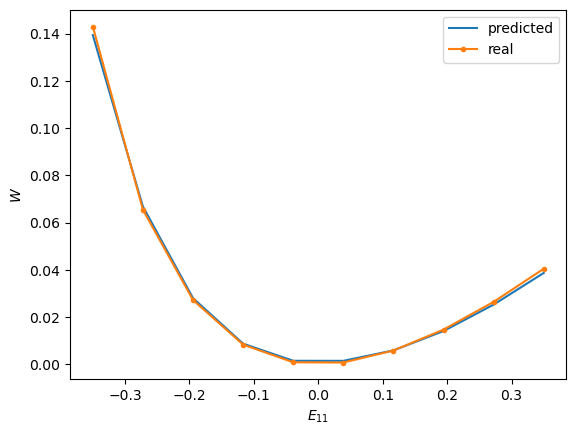

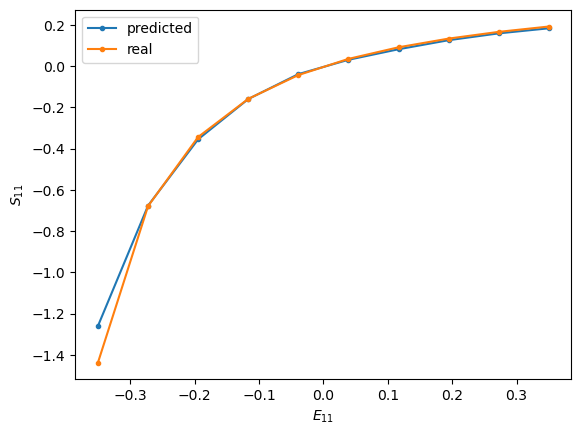

In [11]:
k = 1./3
mu = 0.5
# test with uniaxial strain
E11= np.linspace(-0.35, 0.35 ,10).astype(np.float32)
eps = np.zeros((10,3)).astype(np.float32)
eps[:,0] = E11
eps[:,1] = 0
eps[:,2] = 0

# covert the array into a torch tensor
eps = torch.from_numpy(eps)
eps.requires_grad=True

# compute the predicted energy functional and stress
Psi = model1(eps)
Psi.backward(gradient=torch.ones_like(Psi))
stress=eps.grad

# plot the predicted and true energy functionals
plt.figure(1)
plt.plot(E11, Psi.detach().numpy().reshape(-1))
J = np.sqrt(1+2*E11)
Psi_true = k/2*(J-1)**2 + mu/2*((3+2*E11)/J**(2/3) - 3)
plt.plot(E11, Psi_true, marker='.')
plt.xlabel('$E_{11}$')
plt.ylabel('$W$')
plt.legend(['predicted', 'real'])

# plot the predicted and true stresses
plt.figure(2)
plt.plot(E11, stress.detach().numpy()[:,0], marker='.')
stress_true = k*J*(J-1)/(1+2*E11) + mu/J**(2/3) * 4/3*E11/(1+2*E11)
plt.plot(E11, stress_true, marker='.')
plt.xlabel('$E_{11}$')
plt.ylabel('$S_{11}$')
plt.legend(['predicted', 'real'])
plt.show()


By adding the additional term penalizing the nonconvexity, the trained constitutive model shows better convexity than the previous model (fewer violations of convexity requirements).

In [8]:
# randomly select the test samples
# to save time, reuse the train data
F_test = data['F_train']
P_test = data['P_train']
W_test = data['W_train']

# compute the number of violations of convexity
count=0
for t in range(100000):
    # select two samples
    I = np.random.choice(10000,2)
    F0 = F_test[I[0]] 

    # compute E0, S(E0), W(E0)
    E0 = (np.dot(F0.transpose(),F0)-np.eye(2))/2
    X0 = np.array([[E0[0,0], E0[1,1], 2*E0[0,1]]])
    X0 = torch.tensor(X0.astype(np.float32))
    X0.requires_grad = True
    W0 = model1(X0)
    W0.backward(gradient=torch.ones_like(W0))
    S0 = X0.grad.detach().numpy()
    S0 = np.array([ [S0[0,0], S0[0,2]], [S0[0,2], S0[0,1]] ])
    P0 = np.dot(F0,S0)
    
    # compute E1, W(E1)
    F1 = F_test[I[1]]
    E1 = (np.dot(F1.transpose(),F1)-np.eye(2))/2
    X1 = np.array([[E1[0,0], E1[1,1], 2*E1[0,1]]])
    X1 = torch.tensor(X1.astype(np.float32))
    W1 = model1(X1)
    
    # count if a violation of convexity is found
    if W1-W0-np.trace(np.dot(S0.transpose(), E1-E0)) < 0:
        count += 1
print('number of exceptions:', count)

number of exceptions: 0


## References

1. Vlassis, N. N., Ma, R., & Sun, W. (2020). Geometric deep learning for computational mechanics part i: Anisotropic hyperelasticity. Computer Methods in Applied Mechanics and Engineering, 371, 113299.

2. Vlassis, N. N., & Sun, W. (2021). Sobolev training of thermodynamic-informed neural networks for interpretable elasto-plasticity models with level set hardening. Computer Methods in Applied Mechanics and Engineering, 377, 113695.

3. Le, B. A., Yvonnet, J., & He, Q. C. (2015). Computational homogenization of nonlinear elastic materials using neural networks. International Journal for Numerical Methods in Engineering, 104(12), 1061-1084.

4. Klein, D., Fernández, M., Martin, R. J., Neff, P., & Weeger, O. (2021). Polyconvex anisotropic hyperelasticity with neural networks.

5. Xu, K., Huang, D. Z., & Darve, E. (2021). Learning constitutive relations using symmetric positive definite neural networks. Journal of Computational Physics, 428, 110072.

6. Weber, P., Geiger, J., & Wagner, W. (2021). Constrained neural network training and its application to hyperelastic material modeling. Computational Mechanics, 1-26.

7. Fuhg, Jan N., and Nikolaos Bouklas. "The mixed deep energy method for resolving concentration features in finite strain hyperelasticity." arXiv preprint arXiv:2104.09623 (2021).